In [ ]:
#from sklearn.feature_selection import SelectFromModel, VarianceThreshold
#from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
#from sklearn.model_selection import train_test_split, RandomizedSearchCV
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import train_test_split
#import matplotlib.pyplot as plt
#import joblib
import os
#import pandas as pd
from IPython.display import display
import numpy as np
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))



ModuleNotFoundError: No module named 'sklearn'

(225745, 79)


/var/folders/c9/7s0tqnrd5kld2klkzsbtwhd80000gn/T/ipykernel_75616/3170671696.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'BENIGN': 0, 'DDoS': 1})


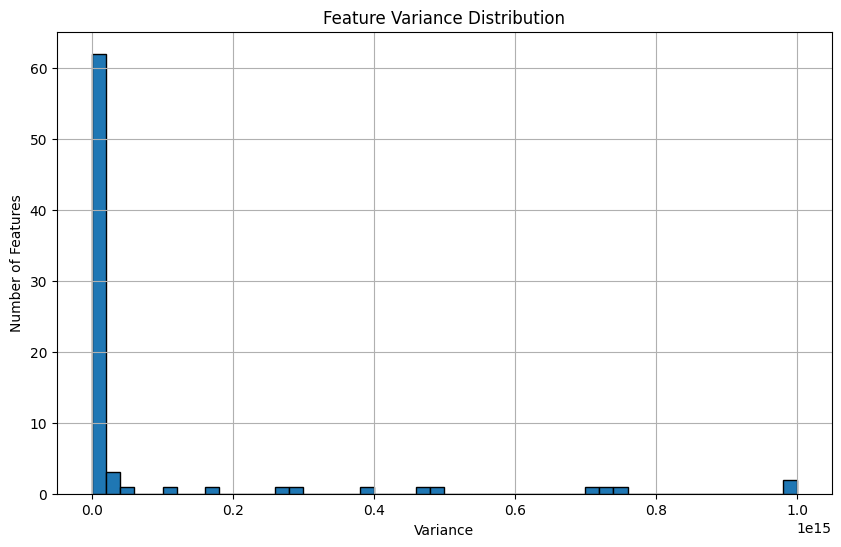

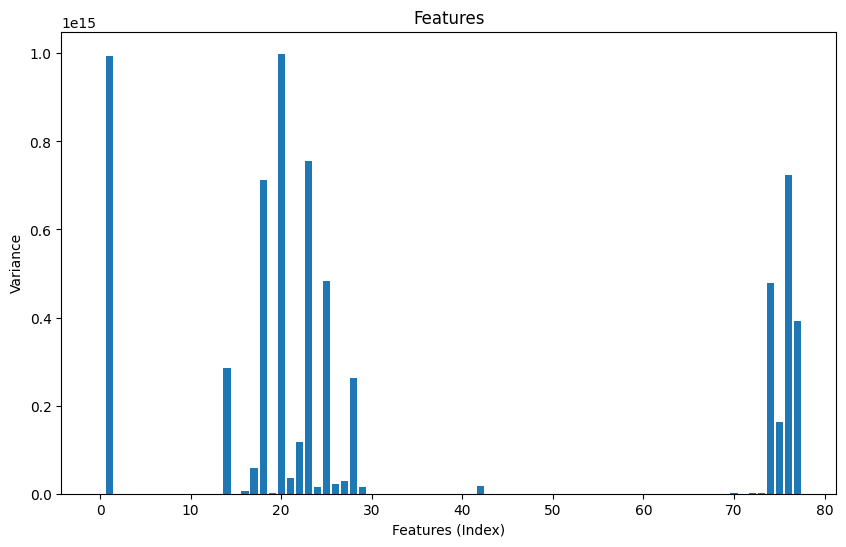

In [3]:
# Load and prepare data
df = pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
print(df.shape)

# Split features and target
X = df.iloc[:, :-1] 
y = df.iloc[:, -1]
y = y.replace({'BENIGN': 0, 'DDoS': 1})
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)


variances = X.var()

# Visualize variances
plt.figure(figsize=(10, 6))
plt.hist(variances, bins=50, edgecolor='k')
plt.title("Feature Variance Distribution")
plt.xlabel("Variance")
plt.ylabel("Number of Features")
plt.grid()
plt.show()

variances = X.var()

# Plot variance distribution
plt.figure(figsize=(10, 6))
plt.bar(range(len(variances)), variances)
plt.title("Features")
plt.xlabel("Features (Index)")
plt.ylabel("Variance")
plt.show()


In [4]:
# Remove bottom 10% of features by variance
percentile_to_remove = 50
threshold = np.percentile(variances, percentile_to_remove)

# Apply VarianceThreshold with the percentile threshold
selector_variance = VarianceThreshold(threshold=threshold)
X_reduced = selector_variance.fit_transform(X)

print(f"Number of features selected: {X_reduced.shape[1]}")


Number of features selected: 39


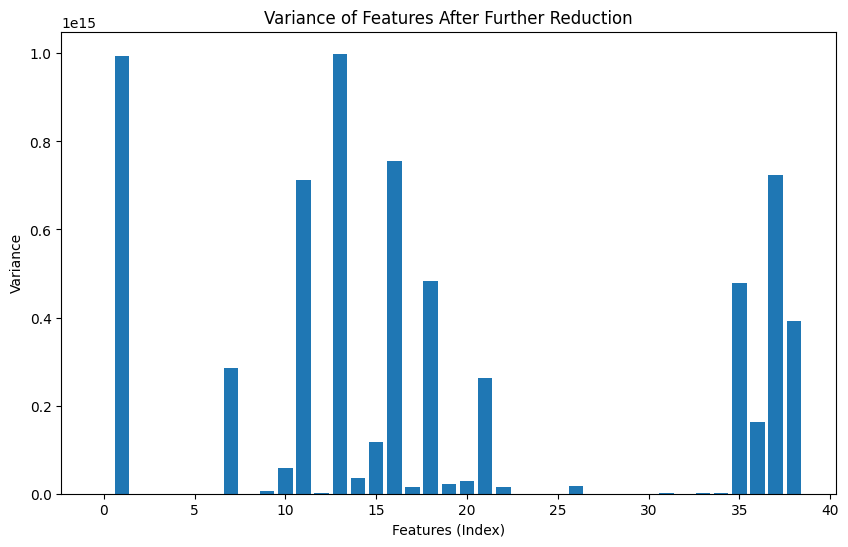

In [5]:
# Recompute and plot variances of reduced features
reduced_variances = pd.DataFrame(X_reduced).var()

plt.figure(figsize=(10, 6))
plt.bar(range(len(reduced_variances)), reduced_variances)
plt.title("Variance of Features After Further Reduction")
plt.xlabel("Features (Index)")
plt.ylabel("Variance")
plt.show()


In [6]:
# Clean and scale features
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(X)

In [7]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_Scaled, y, test_size=0.2, random_state=42)


# Train models with different numbers of estimators
n_estimators_range = [100, 200, 300, 400, 500]
accuracy_scores = []

import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# List available GPUs
print("GPUs:", tf.config.list_physical_devices())


Num GPUs Available:  0
GPUs: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [117]:
def select_features(X, y, threshold='median'):
    selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), 
                             threshold=threshold)
    selector.fit(X, y)
    return selector

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None], 
    'class_weight': ['balanced', 'balanced_subsample', None]
}


# 3. Define custom scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# 4. Implement improved training pipeline
def train_improved_model(X, y):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Feature selection
    selector = select_features(X_train_scaled, y_train)
    X_train_selected = selector.transform(X_train_scaled)
    X_test_selected = selector.transform(X_test_scaled)
    
    # Initialize RandomForestClassifier with base parameters
    rf = RandomForestClassifier(random_state=42, oob_score=True)
    
    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=20,  # Number of parameter settings sampled
        cv=5,       # 5-fold cross-validation
        scoring='f1',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Fit the random search
    random_search.fit(X_train_selected, y_train)
    
    # Get best model
    best_model = random_search.best_estimator_
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test_selected)
    
    # Print results
    print("\nBest Parameters:", random_search.best_params_)
    print("\nCross-validation scores:")
    print("Mean CV Score:", random_search.best_score_)
    print("\nTest Set Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("\nOut-of-bag score:", best_model.oob_score_)
    
    return best_model, selector, scaler

# Train the improved model
best_model, selector, scaler = train_improved_model(X, y)

# Plot feature importances of the best model
def plot_feature_importance(model, feature_names, top_n=20):
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(top_n), importances['importance'][:top_n])
    plt.xticks(range(top_n), importances['feature'][:top_n], rotation=45, ha='right')
    plt.title('Top Feature Importances')
    plt.tight_layout()
    plt.show()
    
    return importances

Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 